In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argosim

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *

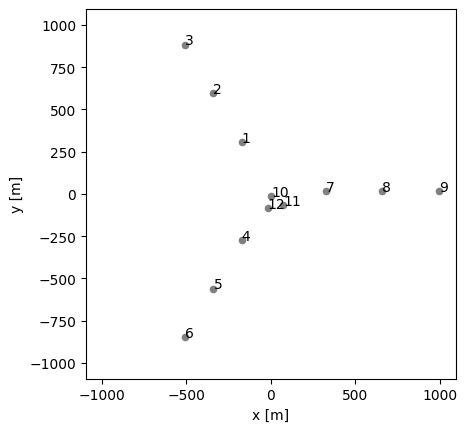

In [2]:
plt.rcParams['image.cmap'] = 'afmhot'

# Antenna parameters
e_lim = 1000
n_lim = 1000
n_antenna = 3
n_baselines = n_antenna*(n_antenna-1)
radius = 1000
alpha = 120

arr_y = y_antenna_arr(n_antenna, radius, alpha)
arr_center = random_antenna_arr(n_antenna=n_antenna, E_lim=e_lim/4, N_lim=n_lim/4)
arr = combine_antenna_arr(arr_y,arr_center)
plot_antenna_arr(arr)


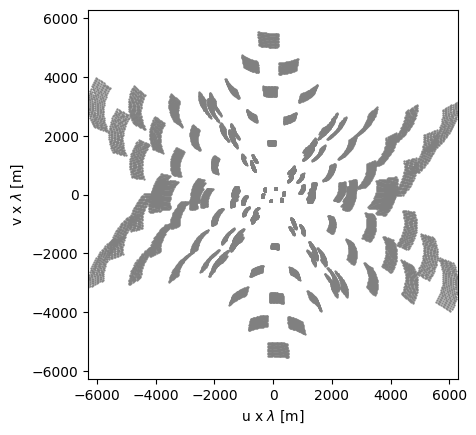

In [3]:
# Source tracking parameters
source_decl = -30/180*np.pi
array_lat = 10.7/180*np.pi
track_time = 2
delta_t = 5/60 # 300 segs
t_0 = -0.5
n_times = int(track_time/delta_t)
# Multiband parameters
f = 1200e6 # 1200 MHz
bandwidth = 100e6
n_freqs = 10

# Get baselines
base_arr = get_baselines(arr)
track = uv_track_multiband(base_arr, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)
plot_baselines(track)

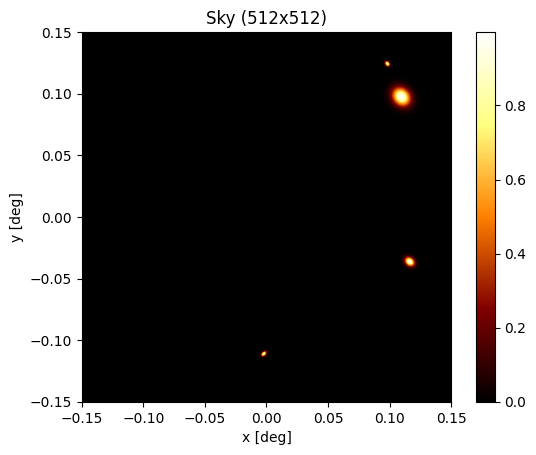

In [4]:
# Sky model
nx = 512
ny = 512
fov_size = (.3, .3)
pix_sizes = [5, 5, 10, 20]
amplitudes = [1, 1, 1, 1]
sky = n_source_sky((nx,ny), pix_sizes, amplitudes)
plot_sky(sky, fov_size)

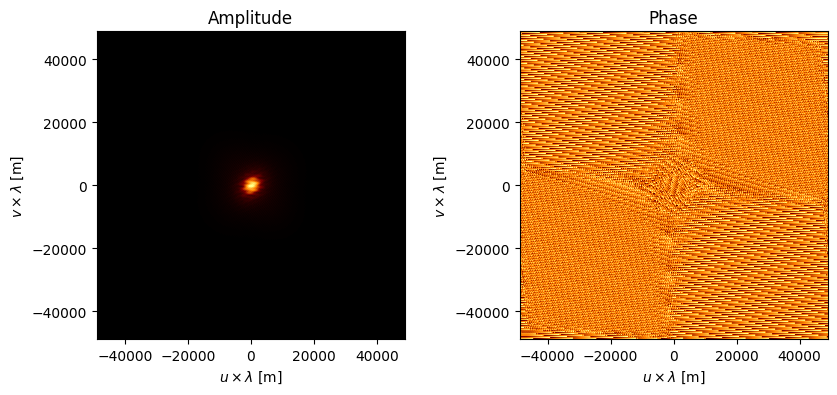

In [5]:
sky_uv = sky2uv(sky)
plot_sky_uv(sky_uv, fov_size)

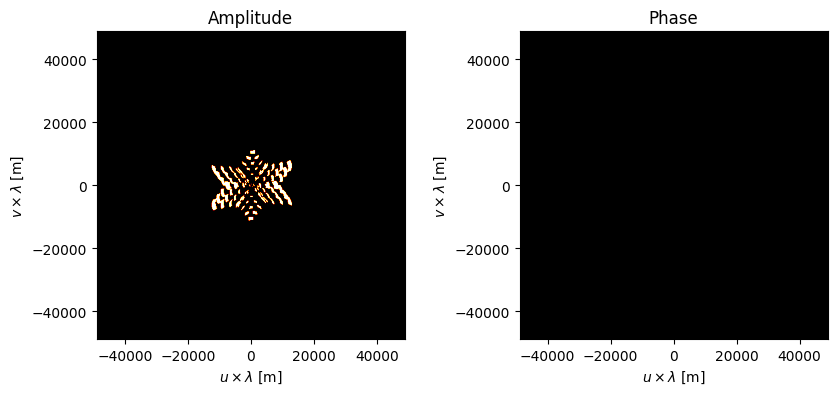

In [6]:
uv_plane_mask, uv_sample_indices = grid_uv_samples(track, sky_uv.shape, fov_size)
plot_sky_uv(uv_plane_mask, fov_size)

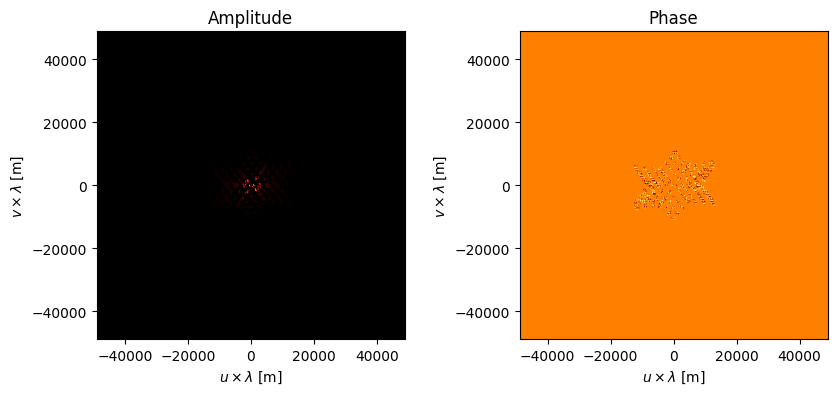

In [7]:
vis = sky_uv*uv_plane_mask+0+0j
plot_sky_uv(vis, fov_size=fov_size)

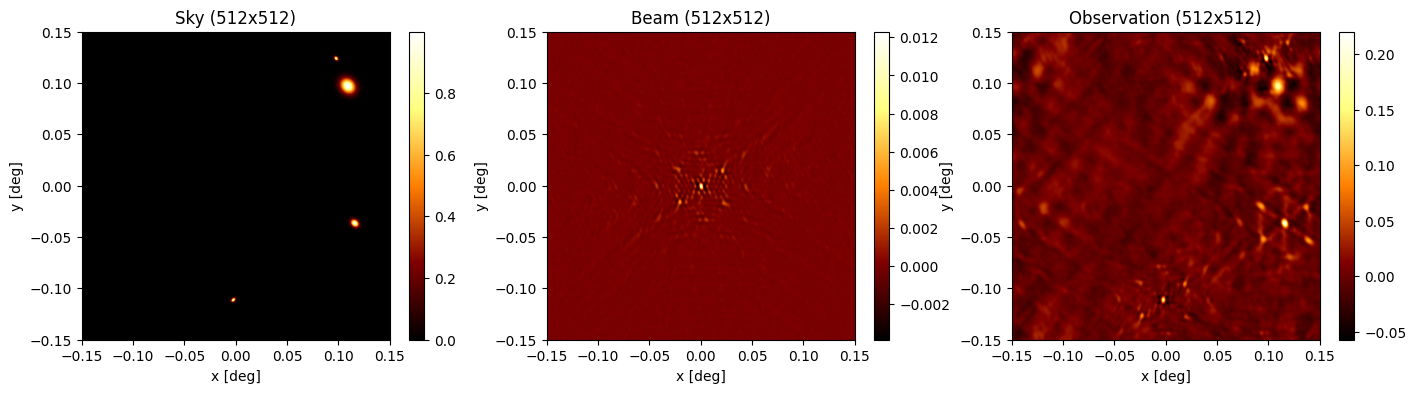

In [8]:
obs = uv2sky(vis)
beam = uv2sky(uv_plane_mask)

fig, ax = plt.subplots(1, 3, figsize=(17,4))
plot_sky(sky, fov_size, ax[0], fig, 'Sky')
plot_sky(beam, fov_size, ax[1], fig, 'Beam')
plot_sky(obs, fov_size, ax[2], fig, 'Observation')

In [9]:
# # Get uv mask
# uv_plane = get_uv_plane(track,uv_dim)
# uv_plane_mask = get_uv_mask(uv_plane)
# # Get the dirty beam
# beam = get_beam(uv_plane)
# # Get the sky model FT
# sky_uv = get_sky_uv(sky)
# # Sample Fourier space
# obs_uv = get_obs_uv(sky_uv,uv_plane_mask)
# # Get observed sky
# obs_sky = get_obs_sky(obs_uv, abs=True)
# # Add noise
# sigma = 3e-3*np.sum(obs_sky**2)
# obs_sky += np.random.randn(obs_sky.shape[0],obs_sky.shape[1])*sigma


In [10]:

#---------------#
# CLEAN algorithm

# Clean hyperparams
max_it = 1000
treshold = 1e-2
clean_gamma = 0.3
clean_beam_size_px = 7 #beam.shape[0]//32


# Clean initialisation
i=0
X=np.zeros(sky.shape)
X_delta = np.zeros(sky.shape)
Y=obs.copy()
B_norm = beam/np.max(beam)
# Get the clean beam
B_clean = gauss_source(nx, ny, np.array([0,0]), fwhm_pix=clean_beam_size_px)

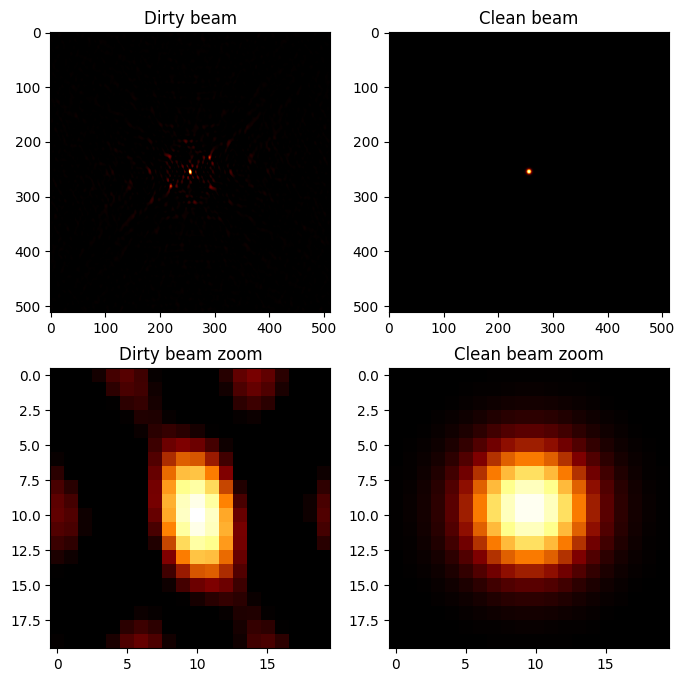

In [11]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(B_norm, vmin=0, vmax=1)
plt.title('Dirty beam')
plt.subplot(2,2,2)
plt.imshow(B_clean, vmin=0, vmax=1)
plt.title('Clean beam')
plt.subplot(2,2,3)
plt.imshow(B_norm[nx//2-10:nx//2+10,ny//2-10:ny//2+10], vmin=0, vmax=1)
plt.title('Dirty beam zoom')
plt.subplot(2,2,4)
plt.imshow(B_clean[nx//2-10:nx//2+10,ny//2-10:ny//2+10], vmin=0, vmax=1)
plt.title('Clean beam zoom')
plt.show()



In [12]:
x_max_list = []
y_max_list = []
max_val_list = []

while i < max_it:
    # Search maximum in dirty obs
    max_val, x_max, y_max, shift_x, shift_y = find_peak(Y)
    if max_val<treshold:
        print('Treshold reached. Stop after {} iterations.'.format(i))
        break
    # Subtract beam
    Y -= max_val*clean_gamma*shift_beam(B_norm, shift_x, shift_y)
    # Save clean component
    X_delta[y_max,x_max] += max_val*clean_gamma
    X += clean_gamma*max_val*shift_beam(B_clean, shift_x, shift_y)
    # Track max peaks
    x_max_list.append(x_max)
    y_max_list.append(y_max)
    max_val_list.append(max_val)
    i+=1

# Add residuals
X += Y

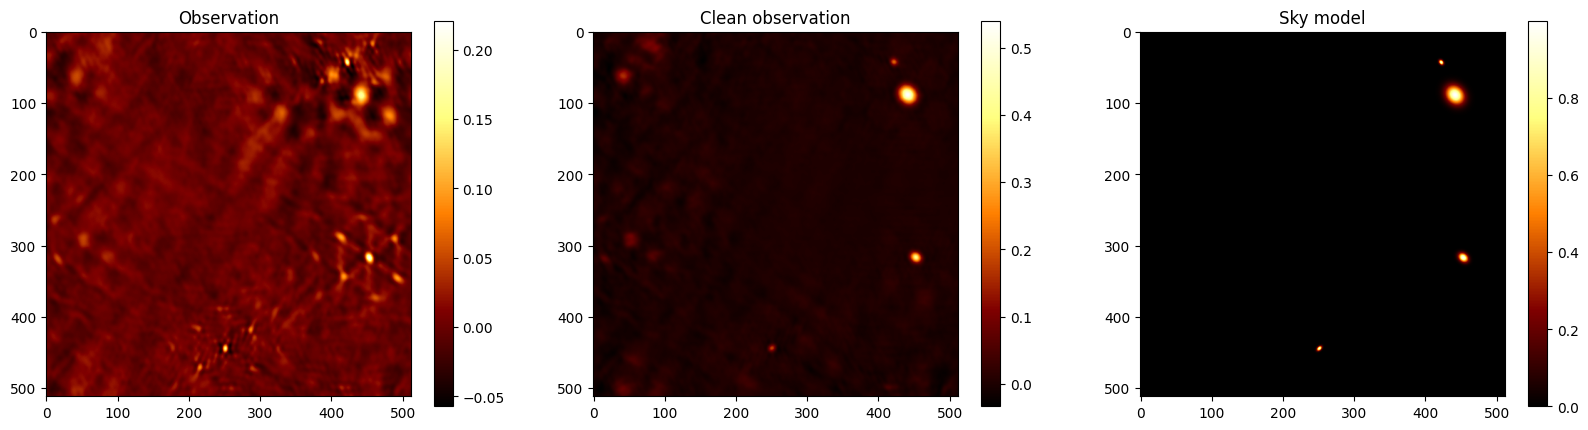

In [13]:
# Plot clean observation
fig, ax = plt.subplots(1,3,figsize=(20,5))
im=ax[0].imshow(obs)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Observation')

im=ax[1].imshow(X)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Clean observation')

im=ax[2].imshow(sky)
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Sky model')


# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()

# Clean function

In [14]:
I_clean, sky_model = clean_hogbom(obs, beam, 0.3, 500, 1e-3 , clean_beam_size_px=10)

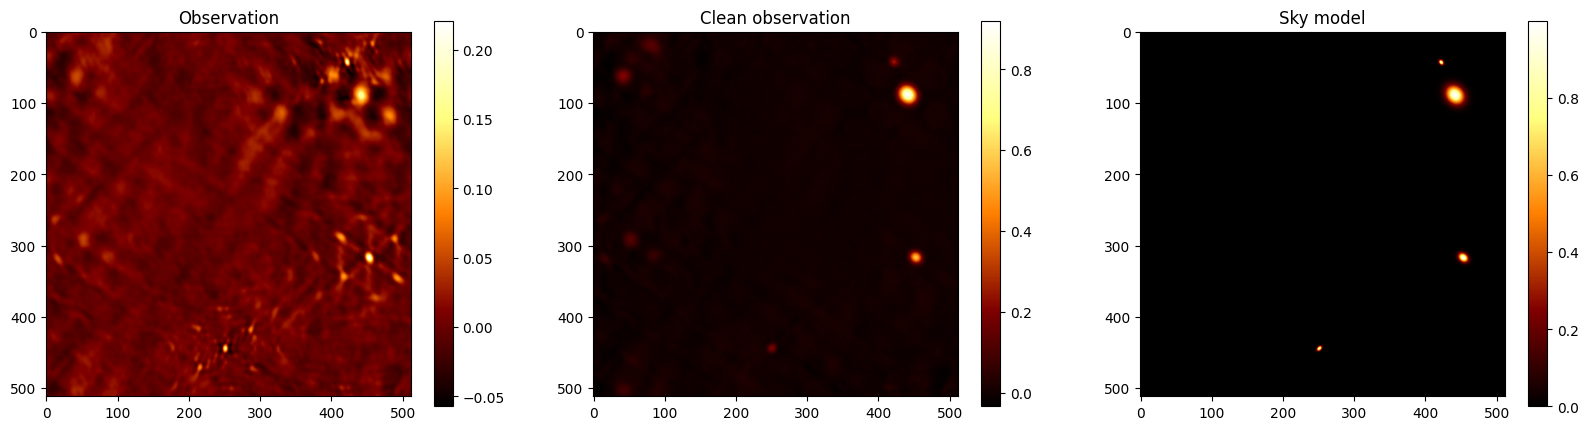

In [15]:
# Plot clean observation
fig, ax = plt.subplots(1,3,figsize=(20,5))
im=ax[0].imshow(obs)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Observation')

im=ax[1].imshow(I_clean)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Clean observation')

im=ax[2].imshow(sky)
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Sky model')


# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()